In [2]:
import math
import json
import string
import requests
from augur.utils import json_to_tree
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import MutableSeq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [52]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-05-15.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

Rather than determing syn/nonsyn differences for each sequence in an alignment, make a tree attribute containing all accumulated differences from root 

In [4]:
# make dictionary with gene name as key and reference sequence of that gene as value
reference_sequence_aa = {}
reference_sequence_nt = {}


# make dictionary giving gene by genomic location 
reference_gene_locations = {}

# make dictionary saying what codon within the gene a certain genomic location falls within
# and whether the mutation is at pos 0, 1 or 2 within codon
reference_gene_codon = {}

for record in SeqIO.parse(open("reference_seq_edited.gb","r"), "genbank"):
    genome_seq = record.seq
    for feature in record.features:
        if feature.type == 'CDS':
            # allow RdRp to overwrite Orf1a and Orf1b, 
            # to take care of changed reading frame due to  ribosome slippage
            # S1 and S2 will also overwrite spike
            for pos in range(int(feature.location.start), int(feature.location.end)):
                reference_gene_locations[pos] = feature.qualifiers['gene'][0]
                codon_num = math.floor((pos-feature.location.start)/3)
                pos_in_codon = ((pos-feature.location.start)-codon_num*3)
                reference_gene_codon[pos] = (codon_num, pos_in_codon)
                
            gene_seq = feature.location.extract(record.seq)
            reference_sequence_nt[feature.qualifiers['gene'][0]] = gene_seq
            gene_seq_aa = gene_seq.translate()
            reference_sequence_aa[feature.qualifiers['gene'][0]] = gene_seq_aa

/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [5]:
# make dictionary with length of each gene
gene_lengths_aa = {k:len(v) for k,v in reference_sequence_aa.items()}
gene_lengths_aa['Nsp6'] = 290
gene_lengths_aa['Nsp4'] = 485

In [6]:
#Function to find path from root to clade
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

In [7]:
def nuc_changes_from_reference(muts_on_path):
    """
    From all the of the nucleotide changes that have occurred on the path from root to branch, 
    find the most recent nuc mutation at each site (giving the genotype at the branch)
    """
    
    final_muts_from_ref = {}

    # overwrites genotypes at pos in historical order
    for x in muts_on_path:
        x_pos = int(x[1:-1])
        final_muts_from_ref[x_pos] = x[-1]
        

    return final_muts_from_ref

In [97]:
def determine_synonymous(nuc_muts_on_branch, parent_diffs_from_ref):
    
    parent_diffs_pos = [int(k) for k,v in parent_diffs_from_ref.items()]

    
    # make dictionary of synonymous (and noncoding) mutations to add to tree
    syn_muts = {}
    
    # don't care about deletions because they are obviously not synonymous
    for mut in nuc_muts_on_branch:
        if mut[-1]!= '-' and mut[0]!='-':
            mut_pos = int(mut[1:-1])
            # find what gene this mut happens in
            if (mut_pos-1) in reference_gene_locations.keys():
                mut_gene = reference_gene_locations[mut_pos-1]
                mut_codon_num = reference_gene_codon[mut_pos-1][0]
                mut_codon_pos = reference_gene_codon[mut_pos-1][1]
                
                # find the reference sequence of the codon this mutation occurs in
                codon_ref_aa = reference_sequence_aa[mut_gene][mut_codon_num]
                
                codon_ref_nt = reference_sequence_nt[mut_gene][(mut_codon_num*3):(mut_codon_num*3+3)]
                
                # check if a mutation occurred within the same codon in a parent
                # and if so, change the reference codon sequence accordingly, 
                # to tell whether the mutation at this branch is synonymous or not
                codon_genome_pos = list(range((mut_pos-1-mut_codon_pos),(mut_pos-1-mut_codon_pos+3)))
                
                parent_codon = codon_ref_nt
                for parent_diff in parent_diffs_pos:
                    parent_diff_zero_based = parent_diff-1
                    if parent_diff_zero_based in codon_genome_pos:
                        parent_diff_pos = codon_genome_pos.index(parent_diff_zero_based)
                        parent_codon = MutableSeq(str(codon_ref_nt))
                        parent_codon[parent_diff_pos] = parent_diffs_from_ref[parent_diff]
                        parent_codon = parent_codon.toseq()
                
                
                codon_mutated = MutableSeq(str(parent_codon))
                #if deletion (or seq error) has happened at neighboring nucleotide
                if '-' in codon_mutated:
                    pass
                else:
                    codon_mutated[mut_codon_pos] = mut[-1]
                    codon_mutated = codon_mutated.toseq()
                    codon_mutated_translation = codon_mutated.translate()

                    if str(codon_ref_aa) == str(codon_mutated_translation):                       
                        if mut_gene in syn_muts.keys():
                            syn_muts[mut_gene] += [mut]
                        else:
                            syn_muts[mut_gene] = [mut]
                        
                

            else:
                if 'noncoding' in syn_muts.keys():
                    syn_muts['noncoding'] += [mut]
                else:
                    syn_muts['noncoding'] = [mut]
                    
    return syn_muts

In [9]:
def add_syn_mut_attribute(tree):
    
    for node in tree.find_clades():

        node.node_attrs['syn_muts'] = {}

        # only care if this branch has some nucleotide mutations
        if hasattr(node, 'branch_attrs'):
            if 'nuc' in node.branch_attrs['mutations']:

                nuc_muts_on_branch = node.branch_attrs['mutations']['nuc']

                node_path = get_parent(tree, node)

                nucleotide_mut_path = []

                # find all nucleotide mutations that happened in parents, 
                # in case they affect codons mutated on this branch
                for parent in node_path[-1]:
                    if hasattr(parent, 'branch_attrs'):
                        if 'nuc' in parent.branch_attrs['mutations']:
                            nucleotide_mut_path+=parent.branch_attrs['mutations']['nuc']

                parent_diffs_from_ref = nuc_changes_from_reference(nucleotide_mut_path)

                syn_muts_dict = determine_synonymous(nuc_muts_on_branch, parent_diffs_from_ref)

                node.node_attrs['syn_muts'] = syn_muts_dict


In [98]:
add_syn_mut_attribute(tree)

In [139]:
#Find the path from root to internal node and accumulate all mutations that have occurred along this path

def consolidate_deletions(mutation_list):
    """
    For deletion mutations, consider adjacent sites as part of the same deletion
    """
    
    without_deletions = [x for x in mutation_list if x[-1]!='-' and x[0]!='-']
    #consolidate deletions and reversions
    deletions_only = [x for x in mutation_list if x[-1]=='-' or x[0]=='-']
    deletions_only.sort(key=lambda x:x[1:-1])
    
    
    #keep track of start of separate deletions
    separate_deletions = []

    # if there are deletions, count a run of consecutive sites as a single deletion/mutation
    if len(deletions_only) != 0:
        separate_deletions.append(deletions_only[0])

        deletion_tracker = int(deletions_only[0][1:-1])
        
        for deletion in deletions_only[1:]:

            deleted_pos = int(deletion[1:-1])
            if deleted_pos == deletion_tracker+1:
                pass
            else:
                separate_deletions.append(deletion)
            deletion_tracker = deleted_pos
    
    consolidated_mutation_list = separate_deletions + without_deletions
            
    return consolidated_mutation_list


def remove_reversions(mutation_list):
    """
    If site mutates and then reverts, do not count this in the mutation tally.
    If site mutates and then mutates again (but not a reversion), count only the second mutation
    """
    mutation_list_pos = [int(x[1:-1]) for x in mutation_list]
    sites_mutated_twice = set([x for x in mutation_list_pos if mutation_list_pos.count(x) > 1])
    # find if twice-mutated site was a reversion
    for site in sites_mutated_twice:
        muts_at_site = [mut for mut in mutation_list if int(mut[1:-1])==site]

        # if site reverts, remove all mutations at this site
        if muts_at_site[0][0] == muts_at_site[-1][-1]:
            for mut in range(len(muts_at_site)):
                mutation_list.remove(muts_at_site[mut])
        # if the site mutates multiple times, but doesn't revert, keep last mutation
        else:
            for mut in range(len(muts_at_site)-1):
                mutation_list.remove(muts_at_site[mut])
    return mutation_list
    
    


for node in tree.find_clades():
    
    
    #Find all parents of the node (includes node too)
    parents = get_parent(tree, node)

    #Find mutations that occur in the parents
    parents_spike_muts = []
    parents_s1_muts = []
    parents_s2_muts = []
    parents_rdrp_muts = []
    parents_nsp6_muts = []
    parents_nsp4_muts = []
    parents_n_muts = []
    parents_e_muts = []
    parents_m_muts = []
    
    parents_s1_syn = []
    parents_s2_syn = []
    parents_rdrp_syn = []
    parents_spike_syn = []
    parents_n_syn = []
    parents_e_syn = []
    parents_m_syn = []
    

    for parent in parents:
        if hasattr(parent, "branch_attrs") and "mutations" in parent.branch_attrs:
            if "S" in parent.branch_attrs["mutations"]:
                parents_spike_muts+=parent.branch_attrs["mutations"]["S"]
                for mut in parent.branch_attrs["mutations"]["S"]: 
                    # nextstrain calls pos 13 in sigpep, not S1
                    if int(mut[1:-1]) in range(14,686):
                        parents_s1_muts+=[mut]
                    elif int(mut[1:-1]) in range(687,1274):
                        parents_s2_muts+=[mut]
            #find RdRp muts
            #and Nsp4 and 6 muts
            elif "ORF1a" in parent.branch_attrs["mutations"]:
                for mut in parent.branch_attrs["mutations"]["ORF1a"]:
                    if int(mut[1:-1]) in range(4492,4401):
                        #renumber mut according to rdrp protein
                        rdrp_mut = f'{mut[0]}{int(mut[1:-1])-4492}{mut[-1]}'
                        parents_rdrp_muts+=[rdrp_mut]
                    elif int(mut[1:-1]) in range(3570,3859):
                        # exclude this ancestral mut
                        if mut!= 'K3833N':
                            #renumber mut according to nsp6 protein
                            nsp6_mut = f'{mut[0]}{int(mut[1:-1])-3570}{mut[-1]}'
                            parents_nsp6_muts+=[nsp6_mut]
                    elif int(mut[1:-1]) in range(2777,3261):
                        #renumber mut according to nsp6 protein
                        nsp4_mut = f'{mut[0]}{int(mut[1:-1])-2777}{mut[-1]}'
                        parents_nsp4_muts+=[nsp4_mut]
            elif "ORF1b" in parent.branch_attrs["mutations"]:
                for mut in parent.branch_attrs["mutations"]["ORF1b"]:
                    if int(mut[1:-1]) in range(1,923):
                        #renumber mut according to rdrp protein
                        rdrp_mut = f'{mut[0]}{int(mut[1:-1])+9}{mut[-1]}'
                        parents_rdrp_muts+=[rdrp_mut]
            # find N muts
            elif "N" in parent.branch_attrs["mutations"]:
                parents_n_muts+=parent.branch_attrs["mutations"]["N"]
            # find E muts
            elif "E" in parent.branch_attrs["mutations"]:
                parents_e_muts+=parent.branch_attrs["mutations"]["E"]
            # find M muts
            elif "M" in parent.branch_attrs["mutations"]:
                parents_m_muts+=parent.branch_attrs["mutations"]["M"]
        if hasattr(parent, 'node_attrs') and 'syn_muts' in parent.node_attrs:
            if 'S' in parent.node_attrs['syn_muts']:
                parents_spike_syn += parent.node_attrs['syn_muts']['S']
            if 'S1' in parent.node_attrs['syn_muts']:
                parents_spike_syn += parent.node_attrs['syn_muts']['S1']
                parents_s1_syn += parent.node_attrs['syn_muts']['S1']
            if 'S2' in parent.node_attrs['syn_muts']:
                parents_spike_syn += parent.node_attrs['syn_muts']['S2']
                parents_s2_syn += parent.node_attrs['syn_muts']['S2']
            if 'RdRp' in parent.node_attrs['syn_muts']:
                parents_rdrp_syn += parent.node_attrs['syn_muts']['RdRp']
            if 'E' in parent.node_attrs['syn_muts']:
                parents_e_syn += parent.node_attrs['syn_muts']['E']
            if 'N' in parent.node_attrs['syn_muts']:
                parents_n_syn += parent.node_attrs['syn_muts']['N']
            if 'M' in parent.node_attrs['syn_muts']:
                parents_m_syn += parent.node_attrs['syn_muts']['M']
            

    # remove reversion mutations from each list
    parents_spike_muts = remove_reversions(parents_spike_muts)
    parents_s1_muts = remove_reversions(parents_s1_muts)
    parents_s2_muts = remove_reversions(parents_s2_muts)
    parents_rdrp_muts = remove_reversions(parents_rdrp_muts)
#     parents_nsp6_muts = remove_reversions(parents_nsp6_muts)
#     parents_nsp4_muts = remove_reversions(parents_nsp4_muts)
    parents_n_muts = remove_reversions(parents_n_muts)
    parents_e_muts = remove_reversions(parents_e_muts)
    parents_m_muts = remove_reversions(parents_m_muts)
    parents_s1_syn = remove_reversions(parents_s1_syn)
    parents_s2_syn = remove_reversions(parents_s2_syn)
    parents_rdrp_syn = remove_reversions(parents_rdrp_syn)
    parents_spike_syn = remove_reversions(parents_spike_syn)
    parents_e_syn = remove_reversions(parents_e_syn)
    parents_n_syn = remove_reversions(parents_n_syn)
    parents_m_syn = remove_reversions(parents_m_syn)


    # count deletion of adjacent nucleotides as one mutation event
    spike_mutation_list = consolidate_deletions(parents_spike_muts)
    s1_mutation_list = consolidate_deletions(parents_s1_muts)
    s2_mutation_list = consolidate_deletions(parents_s2_muts)
    rdrp_mutation_list = consolidate_deletions(parents_rdrp_muts)
#     nsp6_mutation_list = consolidate_deletions(parents_nsp6_muts)
#     nsp4_mutation_list = consolidate_deletions(parents_nsp4_muts)
    n_mutation_list = consolidate_deletions(parents_n_muts)
    e_mutation_list = consolidate_deletions(parents_e_muts)
    m_mutation_list = consolidate_deletions(parents_m_muts)
    s1_syn_mutation_list = consolidate_deletions(parents_s1_syn)
    s2_syn_mutation_list = consolidate_deletions(parents_s2_syn)
    rdrp_syn_mutation_list = consolidate_deletions(parents_rdrp_syn)
    spike_syn_mutation_list = consolidate_deletions(parents_spike_syn)
    n_syn_mutation_list = consolidate_deletions(parents_n_syn)
    e_syn_mutation_list = consolidate_deletions(parents_e_syn)
    m_syn_mutation_list = consolidate_deletions(parents_m_syn)
    
    node.node_attrs["changes_from_ref"] = {'s1_non':s1_mutation_list, 's2_non':s2_mutation_list, 
                                           'rdrp_non':rdrp_mutation_list, 'spike_non':spike_mutation_list,
                                           'e_non':e_mutation_list, 'n_non':n_mutation_list, 
                                           'm_non':m_mutation_list, 
                                           's1_syn': s1_syn_mutation_list, 's2_syn':s2_syn_mutation_list, 
                                           'rdrp_syn': rdrp_syn_mutation_list, 'spike_syn': spike_syn_mutation_list,
                                          'e_syn': e_syn_mutation_list, 'n_syn':n_syn_mutation_list, 
                                          'm_syn': m_syn_mutation_list}
    

In [55]:
first_timepoint = tree.root.node_attrs['num_date']['value']
last_timepoint = 0
for node in tree.find_clades():
    if node.node_attrs['num_date']['value'] > last_timepoint:
        last_timepoint = node.node_attrs['num_date']['value']
        
def make_time_windows(window_len):
    time_windows = np.arange(first_timepoint, last_timepoint, window_len).tolist()
    time_windows += [last_timepoint]
    return time_windows

In [145]:
def find_divergence_in_window(window_len=0.2):
    time_windows = make_time_windows(window_len)
    
#     window_divergence_info = []
    window_dnds_info = []
    
    # look at divergence within time window
    for x in range(1,len(time_windows)):
        start_date = time_windows[x-1]
        end_date = time_windows[x]
        
        s1_div_in_window = []
        s1_syn_div_in_window = []
        rdrp_div_in_window = []
        rdrp_syn_div_in_window = []

        for node in tree.find_clades():
            if node.node_attrs['num_date']['value']>=start_date and  node.node_attrs['num_date']['value']<=end_date:
                
                if len(node.get_terminals())>=3:
                                 

                    s1_div = len(node.node_attrs["changes_from_ref"]['s1_non'])/(gene_lengths_aa['S1']*3*(438/576))
                    
                    #assign a false count to avoid dividing by zero
                    if len(node.node_attrs["changes_from_ref"]['s1_syn']) == 0:
                        s1_syn_div = 1/(gene_lengths_aa['S1']*3*(138/576))
                    else:
                        s1_syn_div = (len(node.node_attrs["changes_from_ref"]['s1_syn'])+1)/(gene_lengths_aa['S1']*3*(138/576))
                    
                    
                    s1_n_over_s = s1_div/s1_syn_div

                    

                    rdrp_div = len(node.node_attrs["changes_from_ref"]['rdrp_non'])/(gene_lengths_aa['RdRp']*3*(438/576))
                    if len(node.node_attrs["changes_from_ref"]['rdrp_syn']) == 0:
                        rdrp_syn_div = 1/(gene_lengths_aa['RdRp']*3*(138/576))
                    else:
                        rdrp_syn_div = (len(node.node_attrs["changes_from_ref"]['rdrp_syn'])+1)/(gene_lengths_aa['RdRp']*3*(138/576))
                        
                    rdrp_n_over_s = rdrp_div/rdrp_syn_div
                    

                    e_div = len(node.node_attrs["changes_from_ref"]['e_non'])/(gene_lengths_aa['E']*3*(438/576))
                    if len(node.node_attrs["changes_from_ref"]['e_syn']) == 0:
                        e_syn_div = 1/(gene_lengths_aa['E']*3*(138/576))
                    else:
                        e_syn_div = (len(node.node_attrs["changes_from_ref"]['e_syn'])+1)/(gene_lengths_aa['E']*3*(138/576))
                        
                    e_n_over_s = e_div/e_syn_div
                    

                    
                    
                    n_div = len(node.node_attrs["changes_from_ref"]['n_non'])/(gene_lengths_aa['N']*3*(438/576))
                    if len(node.node_attrs["changes_from_ref"]['n_syn']) == 0:
                        n_syn_div = 1/(gene_lengths_aa['N']*3*(138/576))
                    else:
                        n_syn_div = (len(node.node_attrs["changes_from_ref"]['n_syn'])+1)/(gene_lengths_aa['N']*3*(138/576))
                        
                    n_n_over_s = n_div/n_syn_div
                    
                    
                    
                    m_div = len(node.node_attrs["changes_from_ref"]['m_non'])/(gene_lengths_aa['M']*3*(438/576))
                    if len(node.node_attrs["changes_from_ref"]['m_syn']) == 0:
                        m_syn_div = 1/(gene_lengths_aa['M']*3*(138/576))
                    else:
                        m_syn_div = (len(node.node_attrs["changes_from_ref"]['m_syn'])+1)/(gene_lengths_aa['M']*3*(138/576))
                        
                    m_n_over_s = m_div/m_syn_div
                    
    

                    s2_div = len(node.node_attrs["changes_from_ref"]['s2_non'])/(gene_lengths_aa['S2']*3*(438/576))
                    if len(node.node_attrs["changes_from_ref"]['s2_syn']) == 0:
                        s2_syn_div = 1/(gene_lengths_aa['S2']*3*(138/576))
                    else:
                        s2_syn_div = (len(node.node_attrs["changes_from_ref"]['s2_syn'])+1)/(gene_lengths_aa['S2']*3*(138/576))
                        
                    s2_n_over_s = s2_div/s2_syn_div
                    
                        
                        
                        
                        
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':s1_n_over_s, 'location': 's1'})
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':rdrp_n_over_s, 'location': 'rdrp'})
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':e_n_over_s, 'location': 'e'})
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':n_n_over_s, 'location': 'n'})
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':m_n_over_s, 'location': 'm'})
                    window_dnds_info.append({'window_start': round(start_date,2), 'window_end': round(end_date,2), 
                                             'dn/ds':s2_n_over_s, 'location': 's2'})



        
                

    window_dnds_df = pd.DataFrame(window_dnds_info)
        

    return window_dnds_df
        

In [146]:
window_dnds = find_divergence_in_window()

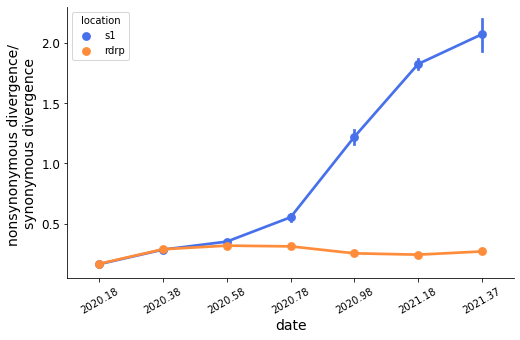

In [144]:
fig, ax = plt.subplots(figsize=(8,5))
cmap = {'rdrp':"#ff8c3a", 's1':"#4770eb", 'e': 'purple', 'n': 'red', 'm': 'green'}

sns.pointplot(x='window_end', y='dn/ds', hue='location', palette=cmap,
              data=window_dnds[(window_dnds['location']=='s1')|(window_dnds['location']=='rdrp')], 
              ci=95, ax=ax)
sns.despine(left=False, bottom=False)
ax.set_xlabel('date', fontsize=14)
ax.set_ylabel('nonsynonymous divergence/ \nsynonymous divergence', fontsize=14)
ax.tick_params(axis='y', which='major', labelsize=12)
ax.tick_params(axis='x', which='major', labelsize=10, rotation=30)



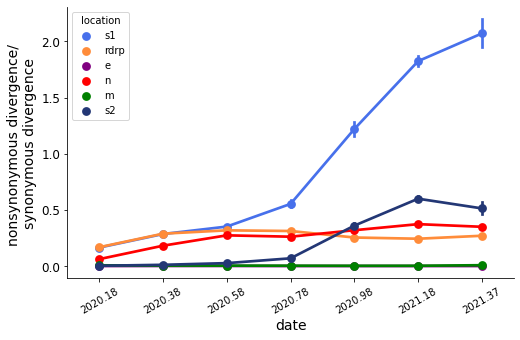

In [151]:
fig, ax = plt.subplots(figsize=(8,5))
cmap = {'rdrp':"#ff8c3a", 's1':"#4770eb", 'e': 'purple', 'n': 'red', 'm': 'green', 's2': '#233775'}

sns.pointplot(x='window_end', y='dn/ds', hue='location', palette=cmap,
              data=window_dnds, 
              ci=95, ax=ax)
sns.despine(left=False, bottom=False)
ax.set_xlabel('date', fontsize=14)
ax.set_ylabel('nonsynonymous divergence/ \nsynonymous divergence', fontsize=14)
ax.tick_params(axis='y', which='major', labelsize=12)
ax.tick_params(axis='x', which='major', labelsize=10, rotation=30)


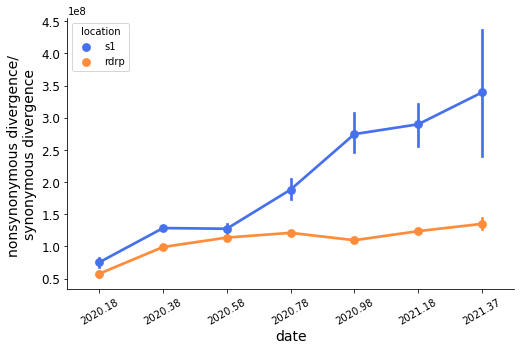

In [79]:
fig, ax = plt.subplots(figsize=(8,5))
cmap = {'rdrp':"#ff8c3a", 's1':"#4770eb"}

sns.pointplot(x='window_end', y='dn/ds', hue='location', palette=cmap,
              data=window_dnds[(window_dnds['location']=='rdrp') | (window_dnds['location']=='s1')], 
              ci=95, ax=ax)
sns.despine(left=False, bottom=False)
ax.set_xlabel('date', fontsize=14)
ax.set_ylabel('nonsynonymous divergence/ \nsynonymous divergence', fontsize=14)
ax.tick_params(axis='y', which='major', labelsize=12)
ax.tick_params(axis='x', which='major', labelsize=10, rotation=30)


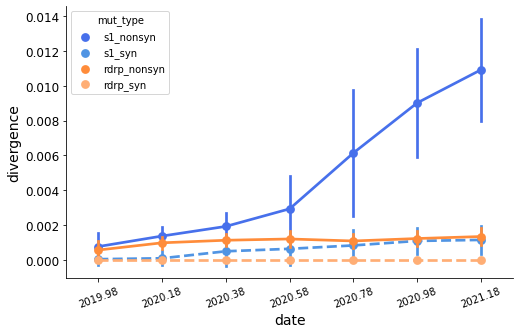

In [81]:
fig, ax = plt.subplots(figsize=(8,5))
cmap = {'rdrp_nonsyn':"#ff8c3a", 'rdrp_syn': "#ffae75", 's1_nonsyn':"#4770eb", 's1_syn':"#5094e3"}


sns.pointplot(x='window_start', y='div', hue='mut_type', palette=cmap,linestyles=["-", "--","-", "--"],
              data=window_divergence[(window_divergence['location']=='rdrp') | (window_divergence['location']=='s1')],
              ci='sd')
sns.despine(left=False, bottom=False)
ax.set_xlabel('date', fontsize=14)
ax.set_ylabel('divergence', fontsize=14)
ax.tick_params(axis='y', which='major', labelsize=12)
ax.tick_params(axis='x', which='major', labelsize=10, rotation=20)

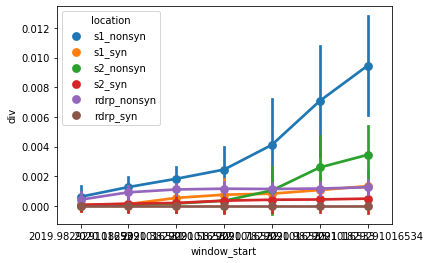

In [89]:
sns.pointplot(x='window_start', y='div', hue='location', data=window_divergence, ci='sd')

In [ ]:
def divergence_weighted(cov, gene, window, clade, min_seqs, year_max=None, year_min=None):
    #Find fraction of sites that differ from root and average among all viruses at each time point
    input_file_root = '../'+str(cov)+'/auspice/seasonal_corona_'+str(cov)+'_'+str(gene)+'_root-sequence.json'
    input_file_alignment = '../'+str(cov)+'/results/aligned_'+str(cov)+'_'+str(gene)+'.fasta'
    metafile = '../'+str(cov)+'/results/metadata_'+str(cov)+'_'+str(gene)+'.tsv'
    
    #Subset data based on time windows
    meta = pd.read_csv(metafile, sep = '\t')
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta.dropna(subset=['date'], inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    
    if year_max:
        meta.drop(meta[meta['year']>year_max].index, inplace=True)
    if year_min:
        meta.drop(meta[meta['year']<year_min].index, inplace=True)

    
    date_range = meta['year'].max() - meta['year'].min()
    
    
    if clade!= None:
        clade_df = separate_clades(cov, gene)
        meta = meta.merge(clade_df, on='strain')
        meta.drop(meta[meta['clade']!=clade].index, inplace=True)

    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['year'].min()) + '-' + str(meta['year'].max())
        virus_time_subset[years] = meta['strain'].tolist()
    else:
        date_window_start = meta['year'].min()
        date_window_end = meta['year'].min() + window
        while date_window_end <= meta['year'].max():
            years = str(date_window_start) + '-' + str(date_window_end)
            strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            #sliding window
            date_window_end += 1
            date_window_start += 1     
    
    root_seq, root_aa_seq, first_window_years = find_founder_consensus(virus_time_subset,input_file_alignment, min_seqs)
    
    nonsyn_denominator, syn_denominator = find_nonsyn_syn_denominators(root_seq, root_aa_seq, cov, clade)

    
    #initiate lists to record all time windows
    year_windows = []
    seqs_in_window = []
    nonsyn_divergences = []
    syn_divergences = []
    nonsyn_divergences_window_average = []
    syn_divergences_window_average = []

    
    for years, subset_viruses in virus_time_subset.items():
    #don't use windows with fewer than min_seqs 
        if len(subset_viruses) >= min_seqs:
            year_windows.append(years)
            seqs_in_window.append(len(subset_viruses))
            

            syn_div_allviruses_in_window = []
            nonsyn_div_allviruses_in_window  = []
            with open(input_file_alignment, "r") as aligned_handle:
                for virus in SeqIO.parse(aligned_handle, "fasta"):         
                    #Only viruses in time window
                    if virus.id in subset_viruses:    
                        #check
                        if len(virus.seq) != len(root_seq):
                            print(virus)
                        elif len(virus.seq) == len(root_seq):
                            count_total_unambiguous = 0
                            count_subs = 0
                            count_syn_subs = 0
                            count_nonsyn_subs = 0
                            for pos in range(len(root_seq)):
                                root_nt = str(root_seq[pos])
                                virus_nt = str(virus.seq[pos])
                                #skip ambiguous sites
                                if virus_nt != 'N':
                                    if root_nt != 'N':
                                        count_total_unambiguous+=1
                                        if virus_nt != root_nt:
                                            count_subs+=1
                                            #determine syn or nonsyn
                                            codon = math.floor(pos/3)
                                            codon_pos = pos-(codon*3)
                                            if codon_pos == 0:
                                                codon_nt = virus.seq[pos:(pos+3)]
                                            elif codon_pos == 1:
                                                codon_nt = virus.seq[(pos-1):(pos+2)]
                                            elif codon_pos == 2:
                                                codon_nt = virus.seq[(pos-2):(pos+1)]
                                            codon_aa = codon_nt.translate()
                                            root_aa = root_aa_seq[codon]
                                            #skip ambiguous
                                            if root_aa != 'X':
                                                if codon_aa != root_aa:
                                                    count_nonsyn_subs+=1
                                                elif codon_aa == root_aa:
                                                    count_syn_subs+=1


                            #Multiply div by fraction of sites that were unambiguously sequenced
                            unambiguous_ratio = count_total_unambiguous/len(root_seq)
                            syn_div_for_virus = (count_syn_subs*unambiguous_ratio)/(syn_denominator*unambiguous_ratio)
#                             syn_div_for_virus = (count_syn_subs)/(syn_denominator)
                            syn_div_allviruses_in_window.append(syn_div_for_virus)
                            nonsyn_div_for_virus = (count_nonsyn_subs*unambiguous_ratio)/(nonsyn_denominator*unambiguous_ratio)
#                             nonsyn_div_for_virus = (count_nonsyn_subs)/(nonsyn_denominator)
                            nonsyn_div_allviruses_in_window.append(nonsyn_div_for_virus)



                mean_syn_div_in_window = sum(syn_div_allviruses_in_window)/len(syn_div_allviruses_in_window)
                mean_nonsyn_div_in_window = sum(nonsyn_div_allviruses_in_window)/len(nonsyn_div_allviruses_in_window)

                syn_divergences.append(syn_div_allviruses_in_window)
                nonsyn_divergences.append(nonsyn_div_allviruses_in_window)

                syn_divergences_window_average.append(mean_syn_div_in_window)
                nonsyn_divergences_window_average.append(mean_nonsyn_div_in_window)

            
    return year_windows, seqs_in_window, syn_divergences, nonsyn_divergences, syn_divergences_window_average, nonsyn_divergences_window_average
